# Temporal MHW Trends

In [1]:
import os
import pickle
from pathlib import Path
from datetime import date

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SAVE_FIGS = False
REPO_ROOT = os.getenv('REPO_ROOT', '/Users/rwegener/repos/chesapeake_mhw')
REPO_ROOT = Path(REPO_ROOT)

### NEXT STEPS
1. Get the 01_define_Bay_zones to output a raster that is the same shape as geopolar (65, 40)
2. Then come back here and switch to using the way of getting mhw average stats from the existing file instead of one per bay.

## Coding Results from Mazzini et al.

Reading MHW Frequency values from Mazzini et al. Figure 4 panels A, C, and E.

Translating my names to the 2 digit codes Mazini uses that denote buoy location.
* UB1 = TB (orange)
* UB2 = TP (blue)
* MB1 = LW (red)
* MB2 = SI (teal)
* LB1 = KP (tan)
* LB2 = GI (purple)

In [3]:
# starting in 2002
freq_dict = {
    'ub1': [1, 0, 1, 4, 1, 3, 1, 1, 7, 3, 6, 2, 1, 4, 5, 7, 4, 4, 6], 
    'ub2': [4, 0, 1, 3, 3, 2, 1, 1, 5, 3, 8, 3, 0, 5, 3, 5, 2, 5, 8], 
    'mb1': [4, 1, 2, 2, 2, 2, 0, 1, 2, 3, 6, 1, 1, 2, 4, 4, 5, 4, 2], 
    'mb2': [1, 0, 1, 2, 1, 3, 0, 2, 5, 2, 4, 3, 0, 3, 4, 8, 5, 3, 5], 
    'lb1': [4, 0, 0, 1, 1, 2, 0, 0, 4, 3, 4, 0, 3, 6, 1, 2, 5, 2, 5], 
    'lb2': [2, 1, 3, 5, 3, 2, 2, 0, 2, 2, 2, 0, 0, 3, 4, 5, 8, 4, 5],
      }

In [4]:
freq = pd.DataFrame(freq_dict, index=pd.to_datetime(range(2002, 2021), format='%Y'))

## Load `mhw.detect` stats output from Geopolar

### Setup

Open zones numbers for masking

In [5]:
trad_zones_rast_ds = xr.open_dataset(
    REPO_ROOT / 'data/interim' / 'chesapeake_traditional_zones.nc'
)
trad_zones_rast = trad_zones_rast_ds.traditional_zones

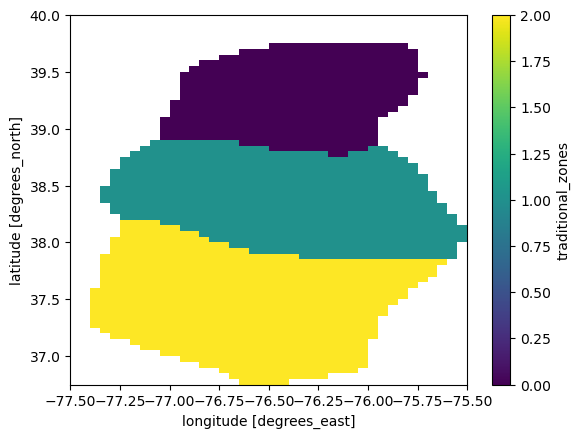

In [6]:
trad_zones_rast.plot()

Frequency function

In [7]:
def no_annual_events(time_arr):
    '''
    counts the number of mhw in each year and returns an array with
    the number of MHW events in each year
    '''
    # getting the years from the start date
    f = lambda x: x.year
    years = np.vectorize(f, otypes=[int])(time_arr['date_start'])
    
    # count the number of events for every year from 2003 to 2021
    # don't include 2002 or 2022 because we don't have the full time series
    year_counts = np.empty(len(range(2003, 2022)))
    for i, yr in enumerate(range(2003, 2022)):
        year_counts[i] = np.count_nonzero(years == yr)
    
    # find the average number of events per year
    return year_counts

### Looking for another way to make the stats by section

In [13]:
trad_zones_rast

<xarray.DataArray 'traditional_zones' (lat: 65, lon: 40)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 36.78 36.83 36.88 36.92 ... 39.83 39.88 39.92 39.97
  * lon      (lon) float32 -77.47 -77.43 -77.38 -77.32 ... -75.62 -75.57 -75.53
Attributes:
    Description:   A raster version of the chesapeake_traditional_zones ona g...
    Source:        chesapeake_traditional_zones.geojson
    grid_mapping:  spatial_ref

In [8]:
# mask_upper = trad_zones_rast.where(trad_zones_rast == 0).values

array([[{'time_start': [], 'time_end': [], 'time_peak': [], 'date_start': [], 'date_end': [], 'date_peak': [], 'index_start': [], 'index_end': [], 'index_peak': [], 'duration': [], 'duration_moderate': [], 'duration_strong': [], 'duration_severe': [], 'duration_extreme': [], 'intensity_max': [], 'intensity_mean': [], 'intensity_var': [], 'intensity_cumulative': [], 'intensity_max_relThresh': [], 'intensity_mean_relThresh': [], 'intensity_var_relThresh': [], 'intensity_cumulative_relThresh': [], 'intensity_max_abs': [], 'intensity_mean_abs': [], 'intensity_var_abs': [], 'intensity_cumulative_abs': [], 'category': [], 'rate_onset': [], 'rate_decline': [], 'n_events': 0},
        {'time_start': [], 'time_end': [], 'time_peak': [], 'date_start': [], 'date_end': [], 'date_peak': [], 'index_start': [], 'index_end': [], 'index_peak': [], 'duration': [], 'duration_moderate': [], 'duration_strong': [], 'duration_severe': [], 'duration_extreme': [], 'intensity_max': [], 'intensity_mean': [], 'in

In [11]:
with open(REPO_ROOT / 'data/interim' / 'mhw_eventstats_dict.pickle', 'rb') as f:
    avg_stats = pickle.load(f)

In [36]:
freq_sat = np.vectorize(no_annual_events, signature='()->(n)')(avg_stats)

In [38]:
np.unique(freq_sat)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [45]:
# For this to work we would need the trad_zones_raster to match the shape
# of the freq_sat
freq_sat_uppbay = freq_sat
freq_sat_uppbay[trad_zones_rast != 0] = np.nan
freq_sat_midbay = freq_sat
freq_sat_midbay[trad_zones_rast != 1] = np.nan
freq_sat_lowbay = freq_sat
freq_sat_lowbay[trad_zones_rast != 2] = np.nan

In [19]:
np.unique(freq_sat_uppbay)

array([nan])

In [ ]:
mhw_nan_pixel_dict = avg_stats[0, 0]

In [ ]:
# .... or maybe we don't need to do this at all, and we can mask after creating
# DataArrays
for i in range(avg_stats.shape[0]):
    for j in range(avg_stats.shape[1]):
        if mask_upper[i, j] is np.nan:
            avg_stats[i, j] = mhw_nan_pixel_dict

In [ ]:
mask_upper[25, 25]

In [ ]:
avg_stats.shape

### Run the function on the full array (back to previous method)

Open the pickled data structures from `stats_calc.ipynb`

In [24]:
with open(REPO_ROOT / 'data/raw/' / 'avg_stats_arr0_UpperBay.pkl','rb') as f:
    avg_stats_uppbay = pickle.load(f)

In [26]:
with open(REPO_ROOT / 'data/raw/' / 'avg_stats_arr0_MiddleBay.pkl','rb') as f:
    avg_stats_midbay = pickle.load(f)

In [27]:
with open(REPO_ROOT / 'data/raw/' / 'avg_stats_arr0_LowerBay.pkl','rb') as f:
    avg_stats_lowbay = pickle.load(f)

[SO post](https://stackoverflow.com/questions/3379301/using-numpy-vectorize-on-functions-that-return-vectors) about generalizing `np.vectorize()` to allow for an array output. 

Create 3D numpy arrays with shape (lon, lat, # of years) to hold the number of marine heatwaves in pixel for each of the years of the times series. The upper, middle, and lower bay each have their own numpy array.

In [48]:
freq_sat_uppbay = np.vectorize(no_annual_events, signature='()->(n)')(avg_stats_uppbay)
freq_sat_midbay = np.vectorize(no_annual_events, signature='()->(n)')(avg_stats_midbay)
freq_sat_lowbay = np.vectorize(no_annual_events, signature='()->(n)')(avg_stats_lowbay)

In [49]:
avg_stats_uppbay.shape

(66, 38)

### Aggregate across space

TODO - is this necessary? If the avg stats are taken by section then this should be repetetive? Better yet, maybe we don't need MHW stats by section so we can use the one for the whole Bay, delete the `.pickle` by bay section and just keep this masking step.

In [63]:
d = {
    "coords": {
        "lat": {"dims": "lat", "data": [0, 1, 2]},
    },
    "dims": "lat",
    "data_vars": {
        "traditional_zones": {"dims": "lat", "data": range(40)},
    },
}
extra = xr.Dataset(d)

TypeError: variable 'coords' has invalid type <class 'dict'>

In [61]:
trad_zones_rast.name

'traditional_zones'

In [60]:
trad_zones_rast.drop_isel(lon=0)

<xarray.DataArray 'traditional_zones' (lat: 65, lon: 39)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 36.78 36.83 36.88 36.92 ... 39.83 39.88 39.92 39.97
  * lon      (lon) float32 -77.43 -77.38 -77.32 -77.28 ... -75.62 -75.57 -75.53
Attributes:
    Description:   A raster version of the chesapeake_traditional_zones ona g...
    Source:        chesapeake_traditional_zones.geojson
    grid_mapping:  spatial_ref

In [51]:
freq_sat_uppbay.shape

(66, 38, 19)

In [44]:
# Mask out any valuse that aren't in the specific section of the Bay.
freq_sat_uppbay[trad_zones_rast != 0] = np.nan
freq_sat_midbay[trad_zones_rast != 1] = np.nan
freq_sat_lowbay[trad_zones_rast != 2] = np.nan

IndexError: boolean index did not match indexed array along dimension 0; dimension is 66 but corresponding boolean dimension is 65

In [ ]:
plt.imshow(freq_sat_uppbay[:, :, 9])
plt.colorbar()

Take the mean frequency of all the pixels in the respective section of the Bay for each year (ex. average frequency of all the pixels in the upper bay).

In [ ]:
freq['ub_sat'] = np.nanmean(freq_sat_uppbay, axis=(0, 1))
freq['mb_sat'] = np.nanmean(freq_sat_midbay, axis=(0, 1))
freq['lb_sat'] = np.nanmean(freq_sat_lowbay, axis=(0, 1))

## Plot

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(14, 3.5)

markers = ['-o', '-s', '-o']

# Adding data to each plot 
freq[['ub1', 'ub2', 'ub_sat']].plot(
    ax=ax1, style=markers, markersize=4, color=[colors[7], colors[7], colors[3]],  # marker='o', 
)
ax1.set_title('Upper Bay')
ax1.legend(['Buoy 1', 'Buoy 2', 'Geo-Polar'])

freq[['mb1', 'mb2', 'mb_sat']].plot(
    ax=ax2, style=markers, markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax2.set_title('Middle Bay')
ax2.legend(['Buoy 3', 'Buoy 4', 'Geo-Polar'])

freq[['lb1', 'lb2', 'lb_sat']].plot(
    ax=ax3, style=markers, markersize=4, color=[colors[7], colors[7], colors[3]],
)
ax3.set_title('Lower Bay', pad=10)
ax3.legend(['Buoy 5', 'Buoy 6', 'Geo-Polar'])


# Setting params that are the same for all 3 plots
for ax in (ax1, ax2, ax3):
    ax.set_xlim([date(2001, 10, 1), date(2021, 3, 1)])

    ax.set_ylabel('Frequency (events/year)')

fig.suptitle('Long term trend in MHW frequency: Buoy and satellite datasets', y=1.05, 
            fontsize=16)

plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis', 
                         'mazzini_comparison.png'), 
            dpi=350, bbox_inches='tight')
